# Reinforcement Learning with Deep Q-Networks (DQN)

## Project Overview
Train an agent with a Deep Q-Network to solve the CartPole balancing task in OpenAI Gym. This project demonstrates:

- **Reinforcement Learning Basics**: environment, agent, states, actions, rewards, episodes
- **Deep Q-Networks**: function approximation with neural networks
- **Experience Replay**: sampling past transitions to break correlations
- **Target Networks**: stabilizing learning by decoupling target calculation
- **ε-greedy Exploration**: balancing exploration vs. exploitation

### Goal
Achieve an average reward of ≥475 over 100 consecutive episodes to "solve" CartPole-v1.

In [1]:
# Install required packages
!pip install gym torch numpy matplotlib collections

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     --------------------------- ---------- 524.3/721.7 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [1]:
# Import necessary libraries
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Gymnasium version: {gym.__version__}")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Libraries imported successfully!
PyTorch version: 2.7.1+cpu
Gymnasium version: 1.2.0
Using device: cpu


## 1. Environment Exploration

Let's first understand the CartPole environment structure and dynamics.

In [3]:
# Create and inspect the CartPole environment
env = gym.make("CartPole-v1")

print("=== CartPole Environment Information ===")
print(f"State space: {env.observation_space}")
print(f"State space shape: {env.observation_space.shape}")
print(f"Action space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")

# Reset environment to get initial state (gymnasium returns tuple)
state, info = env.reset()
print(f"\nInitial state shape: {state.shape}")
print(f"Initial state: {state}")

print("\n=== State Space Description ===")
print("The state is a 4-dimensional vector representing:")
print("1. Cart Position: [-4.8, 4.8]")
print("2. Cart Velocity: [-∞, ∞]")
print("3. Pole Angle: [-0.418, 0.418] radians (~24°)")
print("4. Pole Angular Velocity: [-∞, ∞]")

print("\n=== Action Space Description ===")
print("0: Push cart to the left")
print("1: Push cart to the right")

print("\n=== Reward Structure ===")
print("Reward: +1 for every timestep the pole remains upright")
print("Episode ends when:")
print("- Pole angle > ±12° (0.2095 radians)")
print("- Cart position > ±2.4")
print("- Episode length > 500 timesteps")
print("- Solved when average reward ≥ 475 over 100 episodes")

=== CartPole Environment Information ===
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
State space shape: (4,)
Action space: Discrete(2)
Number of actions: 2

Initial state shape: (4,)
Initial state: [ 0.02329404  0.00021743  0.0455251  -0.00767023]

=== State Space Description ===
The state is a 4-dimensional vector representing:
1. Cart Position: [-4.8, 4.8]
2. Cart Velocity: [-∞, ∞]
3. Pole Angle: [-0.418, 0.418] radians (~24°)
4. Pole Angular Velocity: [-∞, ∞]

=== Action Space Description ===
0: Push cart to the left
1: Push cart to the right

=== Reward Structure ===
Reward: +1 for every timestep the pole remains upright
Episode ends when:
- Pole angle > ±12° (0.2095 radians)
- Cart position > ±2.4
- Episode length > 500 timesteps
- Solved when average reward ≥ 475 over 100 episodes


In [4]:
# Demonstrate a random agent for baseline comparison
def test_random_agent(episodes=5):
    """Test random agent performance for baseline comparison"""
    total_rewards = []
    
    for episode in range(episodes):
        state, info = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = env.action_space.sample()  # Random action
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            # In gymnasium, episode ends when done OR truncated
            if truncated:
                done = True
            
        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")
    
    avg_reward = np.mean(total_rewards)
    print(f"\nRandom Agent Average Reward: {avg_reward:.2f}")
    return total_rewards

print("=== Random Agent Baseline ===")
random_rewards = test_random_agent()

=== Random Agent Baseline ===
Episode 1: Reward = 13.0
Episode 2: Reward = 23.0
Episode 3: Reward = 22.0
Episode 4: Reward = 17.0
Episode 5: Reward = 13.0

Random Agent Average Reward: 17.60


## 2. Deep Q-Network (DQN) Implementation

Now let's implement the core components of DQN:
1. **Neural Network Architecture**: Q-network to approximate Q-values
2. **Experience Replay Buffer**: Store and sample past experiences
3. **DQN Agent**: Main agent class with training logic
4. **Target Network**: Stable target for Q-learning updates

In [5]:
# Define the Q-Network architecture
class QNetwork(nn.Module):
    """
    Deep Q-Network for approximating Q-values
    
    Architecture:
    - Input: 4-dimensional state
    - Hidden layers: 2 layers with 128 neurons each
    - Output: Q-values for 2 actions
    """
    
    def __init__(self, state_size=4, action_size=2, hidden_size=128):
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        """Forward pass through the network"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Test the network
test_network = QNetwork()
test_state = torch.FloatTensor([0.1, 0.2, 0.3, 0.4]).unsqueeze(0)
test_output = test_network(test_state)

print("=== Q-Network Architecture ===")
print(f"Network: {test_network}")
print(f"Input shape: {test_state.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output Q-values: {test_output.detach().numpy()}")

# Count parameters
total_params = sum(p.numel() for p in test_network.parameters())
print(f"Total parameters: {total_params:,}")

=== Q-Network Architecture ===
Network: QNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Input shape: torch.Size([1, 4])
Output shape: torch.Size([1, 2])
Output Q-values: [[0.00431979 0.00088482]]
Total parameters: 17,410


In [6]:
# Experience Replay Buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """
    Experience Replay Buffer for storing and sampling past experiences
    
    This breaks temporal correlations in the data and stabilizes training
    """
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        """Add an experience to the buffer"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        """Sample a random batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.FloatTensor([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# Test the replay buffer
print("=== Experience Replay Buffer ===")
replay_buffer = ReplayBuffer(capacity=1000)

# Add some dummy experiences
for i in range(5):
    state = np.random.random(4)
    action = random.choice([0, 1])
    reward = random.random()
    next_state = np.random.random(4)
    done = random.choice([True, False])
    
    replay_buffer.push(state, action, reward, next_state, done)

print(f"Buffer size: {len(replay_buffer)}")

# Sample a batch
if len(replay_buffer) >= 3:
    states, actions, rewards, next_states, dones = replay_buffer.sample(3)
    print(f"Sample batch shapes:")
    print(f"  States: {states.shape}")
    print(f"  Actions: {actions.shape}")
    print(f"  Rewards: {rewards.shape}")
    print(f"  Next states: {next_states.shape}")
    print(f"  Dones: {dones.shape}")

=== Experience Replay Buffer ===
Buffer size: 5
Sample batch shapes:
  States: torch.Size([3, 4])
  Actions: torch.Size([3])
  Rewards: torch.Size([3])
  Next states: torch.Size([3, 4])
  Dones: torch.Size([3])


In [7]:
# DQN Agent Implementation
class DQNAgent:
    """
    Deep Q-Network Agent with Experience Replay and Target Network
    
    Key features:
    - ε-greedy exploration strategy
    - Experience replay for stable learning
    - Target network for stable Q-learning updates
    - Soft target network updates
    """
    
    def __init__(self, state_size=4, action_size=2, lr=0.001, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64, update_every=4,
                 tau=0.001):
        
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.update_every = update_every
        self.tau = tau  # Soft update parameter
        
        # Q-Networks
        self.q_network_local = QNetwork(state_size, action_size).to(device)
        self.q_network_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network_local.parameters(), lr=lr)
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)
        
        # Initialize time step for updating target network
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        """Save experience and learn from a batch of experiences"""
        # Save experience to replay buffer
        self.memory.push(state, action, reward, next_state, done)
        
        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # Learn if enough samples are available in memory
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample(self.batch_size)
                self.learn(experiences)
    
    def act(self, state, training=True):
        """Choose action using ε-greedy policy"""
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        # Get Q-values for current state
        self.q_network_local.eval()
        with torch.no_grad():
            action_values = self.q_network_local(state)
        self.q_network_local.train()
        
        # ε-greedy action selection
        if training and random.random() < self.epsilon:
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())
    
    def learn(self, experiences):
        """Update Q-network using batch of experiences"""
        states, actions, rewards, next_states, dones = experiences
        
        # Move to device
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (~dones).unsqueeze(1))
        
        # Get expected Q values from local model
        Q_expected = self.q_network_local(states).gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.soft_update(self.q_network_local, self.q_network_target, self.tau)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters: θ_target = τ*θ_local + (1 - τ)*θ_target"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

print("=== DQN Agent Initialized ===")
agent = DQNAgent()
print(f"Agent created with parameters:")
print(f"  Learning rate: {agent.lr}")
print(f"  Gamma (discount): {agent.gamma}")
print(f"  Initial epsilon: {agent.epsilon}")
print(f"  Buffer size: {len(agent.memory)}")
print(f"  Batch size: {agent.batch_size}")

=== DQN Agent Initialized ===
Agent created with parameters:
  Learning rate: 0.001
  Gamma (discount): 0.99
  Initial epsilon: 1.0
  Buffer size: 0
  Batch size: 64
Agent created with parameters:
  Learning rate: 0.001
  Gamma (discount): 0.99
  Initial epsilon: 1.0
  Buffer size: 0
  Batch size: 64


## 3. Training Loop Implementation

Now let's implement the main training loop that will train our DQN agent to solve CartPole.

In [9]:
# Training function with monitoring
def train_dqn(agent, env, n_episodes=2000, max_t=500, target_score=475.0, 
              print_every=100, save_every=200):
    """
    Train the DQN agent
    
    Args:
        agent: DQN agent
        env: OpenAI Gym environment
        n_episodes: Maximum number of episodes
        max_t: Maximum timesteps per episode
        target_score: Target average score over 100 episodes
        print_every: Print progress every N episodes
        save_every: Save model every N episodes
    """
    
    scores = []  # List of scores from each episode
    scores_window = deque(maxlen=100)  # Last 100 scores
    losses = []  # Track training losses
    epsilons = []  # Track epsilon decay
    
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()
        score = 0
        episode_losses = []
        
        for t in range(max_t):
            # Agent selects action
            action = agent.act(state, training=True)
            
            # Environment responds (gymnasium returns 5 values)
            next_state, reward, done, truncated, info = env.step(action)
            
            # Agent learns from experience
            agent.step(state, action, reward, next_state, done or truncated)
            
            # Track losses if learning occurred
            if len(agent.memory) > agent.batch_size and agent.t_step == 0:
                # Get the most recent loss (this is approximate)
                loss = agent.learn(agent.memory.sample(agent.batch_size))
                episode_losses.append(loss)
            
            state = next_state
            score += reward
            
            if done or truncated:
                break
        
        # Save episode results
        scores.append(score)
        scores_window.append(score)
        epsilons.append(agent.epsilon)
        
        if episode_losses:
            losses.append(np.mean(episode_losses))
        else:
            losses.append(0)
        
        # Print progress
        if i_episode % print_every == 0:
            avg_score = np.mean(scores_window)
            print(f'Episode {i_episode:4d}\tAverage Score: {avg_score:.2f}\t'
                  f'Epsilon: {agent.epsilon:.3f}\tLoss: {losses[-1]:.4f}')
        
        # Check if environment is solved
        if len(scores_window) >= 100 and np.mean(scores_window) >= target_score:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\t'
                  f'Average Score: {np.mean(scores_window):.2f}')
            # Save final model
            torch.save(agent.q_network_local.state_dict(), 'dqn_cartpole_solved.pth')
            break
        
        # Save model periodically
        if i_episode % save_every == 0:
            torch.save(agent.q_network_local.state_dict(), f'dqn_cartpole_{i_episode}.pth')
    
    return scores, losses, epsilons

print("=== Training Function Ready ===")
print("The training function will:")
print("1. Run episodes with ε-greedy exploration")
print("2. Store experiences in replay buffer")
print("3. Train the network on random batches")
print("4. Update target network periodically")
print("5. Monitor progress and save models")
print("6. Stop when average reward ≥ 475 over 100 episodes")

=== Training Function Ready ===
The training function will:
1. Run episodes with ε-greedy exploration
2. Store experiences in replay buffer
3. Train the network on random batches
4. Update target network periodically
5. Monitor progress and save models
6. Stop when average reward ≥ 475 over 100 episodes


In [10]:
# Initialize a fresh agent and start training
print("=== Starting DQN Training ===")
print("This may take several minutes...")

# Create fresh environment and agent
env = gym.make("CartPole-v1")
agent = DQNAgent(
    state_size=4,
    action_size=2,
    lr=0.0005,          # Learning rate
    gamma=0.99,         # Discount factor
    epsilon=1.0,        # Initial exploration
    epsilon_decay=0.995, # Exploration decay
    epsilon_min=0.01,   # Minimum exploration
    buffer_size=10000,  # Replay buffer size
    batch_size=64,      # Training batch size
    update_every=4,     # Learn every N steps
    tau=0.001          # Soft update rate
)

print(f"Training parameters:")
print(f"  Learning Rate: {agent.lr}")
print(f"  Gamma: {agent.gamma}")
print(f"  Epsilon: {agent.epsilon} → {agent.epsilon_min}")
print(f"  Buffer Size: {len(agent.memory)}")
print(f"  Batch Size: {agent.batch_size}")

# Start training (reduced episodes for demonstration)
scores, losses, epsilons = train_dqn(
    agent=agent,
    env=env,
    n_episodes=500,  # Reduced for demo - increase for full training
    max_t=500,
    target_score=475.0,
    print_every=50,
    save_every=200
)

=== Starting DQN Training ===
This may take several minutes...
Training parameters:
  Learning Rate: 0.0005
  Gamma: 0.99
  Epsilon: 1.0 → 0.01
  Buffer Size: 0
  Batch Size: 64
Episode   50	Average Score: 15.42	Epsilon: 0.171	Loss: 0.0002
Episode   50	Average Score: 15.42	Epsilon: 0.171	Loss: 0.0002
Episode  100	Average Score: 13.25	Epsilon: 0.043	Loss: 0.0007
Episode  100	Average Score: 13.25	Epsilon: 0.043	Loss: 0.0007
Episode  150	Average Score: 11.04	Epsilon: 0.011	Loss: 0.0016
Episode  150	Average Score: 11.04	Epsilon: 0.011	Loss: 0.0016
Episode  200	Average Score: 11.73	Epsilon: 0.010	Loss: 0.0058
Episode  200	Average Score: 11.73	Epsilon: 0.010	Loss: 0.0058
Episode  250	Average Score: 13.41	Epsilon: 0.010	Loss: 0.0081
Episode  250	Average Score: 13.41	Epsilon: 0.010	Loss: 0.0081
Episode  300	Average Score: 16.95	Epsilon: 0.010	Loss: 0.0176
Episode  300	Average Score: 16.95	Epsilon: 0.010	Loss: 0.0176
Episode  350	Average Score: 25.83	Epsilon: 0.010	Loss: 0.0195
Episode  350	Ave

## 4. Training Results Visualization

Let's visualize the training progress and analyze the agent's performance.

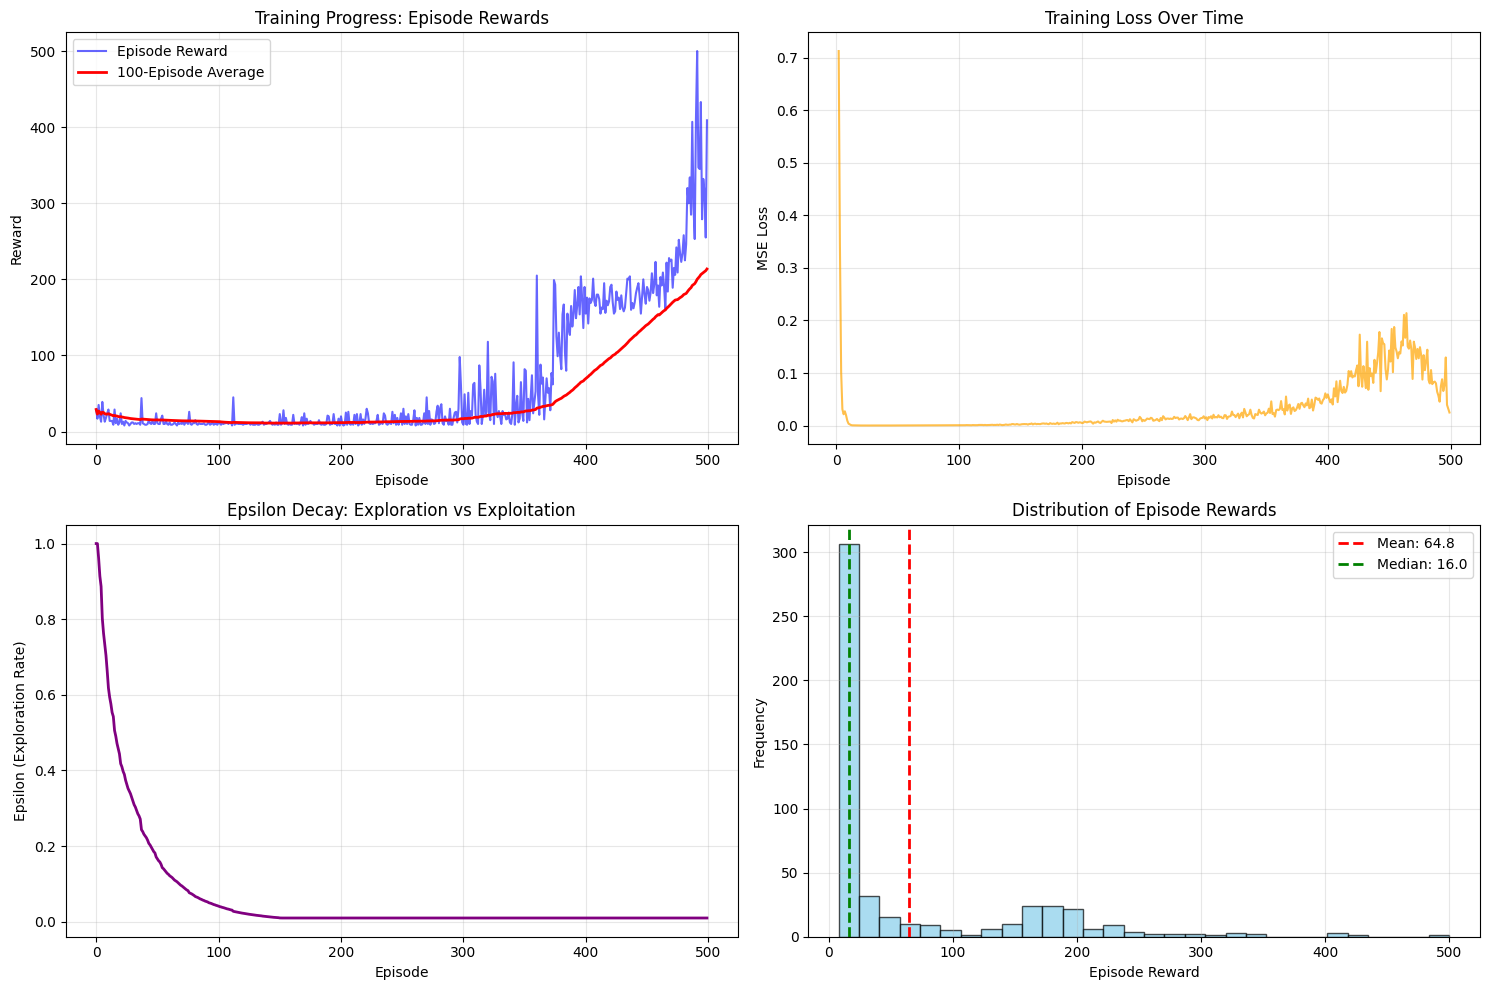

=== Training Summary ===
Total Episodes: 500
Average Reward: 64.77
Best Episode: 500
Final 100-episode average: 213.61
Environment not yet solved
Final Epsilon: 0.0100


In [12]:
# Comprehensive training results visualization
def plot_training_results(scores, losses, epsilons):
    """Create comprehensive plots of training progress"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Episode Rewards
    axes[0, 0].plot(scores, alpha=0.6, color='blue', label='Episode Reward')
    
    # Calculate rolling average
    if len(scores) >= 100:
        rolling_avg = []
        for i in range(len(scores)):
            if i >= 99:
                rolling_avg.append(np.mean(scores[i-99:i+1]))
            else:
                rolling_avg.append(np.mean(scores[:i+1]))
        axes[0, 0].plot(rolling_avg, color='red', linewidth=2, label='100-Episode Average')
        
        # Mark solved point if achieved
        if max(rolling_avg) >= 475:
            solved_episode = next(i for i, avg in enumerate(rolling_avg) if avg >= 475)
            axes[0, 0].axhline(y=475, color='green', linestyle='--', alpha=0.7, label='Solved Threshold')
            axes[0, 0].axvline(x=solved_episode, color='green', linestyle='--', alpha=0.7)
            axes[0, 0].text(solved_episode, 475, f'Solved at episode {solved_episode}', 
                          rotation=90, verticalalignment='bottom')
    
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].set_title('Training Progress: Episode Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Training Loss
    if losses and any(l > 0 for l in losses):
        non_zero_losses = [l for l in losses if l > 0]
        loss_episodes = [i for i, l in enumerate(losses) if l > 0]
        axes[0, 1].plot(loss_episodes, non_zero_losses, color='orange', alpha=0.7)
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('MSE Loss')
        axes[0, 1].set_title('Training Loss Over Time')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No loss data available', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Training Loss (No Data)')
    
    # 3. Epsilon Decay
    axes[1, 0].plot(epsilons, color='purple', linewidth=2)
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Epsilon (Exploration Rate)')
    axes[1, 0].set_title('Epsilon Decay: Exploration vs Exploitation')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Performance Distribution
    if len(scores) > 0:
        axes[1, 1].hist(scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].axvline(np.mean(scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(scores):.1f}')
        axes[1, 1].axvline(np.median(scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(scores):.1f}')
        axes[1, 1].set_xlabel('Episode Reward')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Distribution of Episode Rewards')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Training Summary ===")
    print(f"Total Episodes: {len(scores)}")
    if scores:
        print(f"Average Reward: {np.mean(scores):.2f}")
        print(f"Best Episode: {max(scores):.0f}")
        print(f"Final 100-episode average: {np.mean(scores[-100:]):.2f}")
        
        if len(scores) >= 100:
            rolling_avg = [np.mean(scores[max(0, i-99):i+1]) for i in range(len(scores))]
            if max(rolling_avg) >= 475:
                solved_ep = next(i for i, avg in enumerate(rolling_avg) if avg >= 475)
                print(f"Environment solved at episode: {solved_ep}")
            else:
                print("Environment not yet solved")
        
        print(f"Final Epsilon: {epsilons[-1]:.4f}" if epsilons else "No epsilon data")

# Plot results if training data exists
if 'scores' in locals() and scores:
    plot_training_results(scores, losses, epsilons)
else:
    print("No training data available yet. Run the training cell first!")

## 5. Testing the Trained Agent

Let's test our trained agent and compare its performance with the random baseline.

=== Agent Performance Comparison ===

Testing Trained DQN Agent...
Episode  20/100  Average Score: 237.40
Episode  20/100  Average Score: 237.40
Episode  40/100  Average Score: 235.40
Episode  40/100  Average Score: 235.40
Episode  60/100  Average Score: 235.15
Episode  60/100  Average Score: 235.15
Episode  80/100  Average Score: 235.21
Episode  80/100  Average Score: 235.21
Episode 100/100  Average Score: 236.06

Trained Agent Results:
  Average Score: 236.06 ± 14.29
  Best Score: 266.0
  Success Rate (≥475): 0.0%

Testing Random Agent...
Episode 1: Reward = 15.0
Episode 2: Reward = 17.0
Episode 3: Reward = 21.0
Episode 4: Reward = 19.0
Episode 5: Reward = 14.0
Episode 6: Reward = 20.0
Episode 7: Reward = 24.0
Episode 8: Reward = 16.0
Episode 9: Reward = 12.0
Episode 10: Reward = 39.0
Episode 11: Reward = 20.0
Episode 12: Reward = 15.0
Episode 13: Reward = 13.0
Episode 14: Reward = 45.0
Episode 15: Reward = 19.0
Episode 16: Reward = 9.0
Episode 17: Reward = 17.0
Episode 18: Reward = 

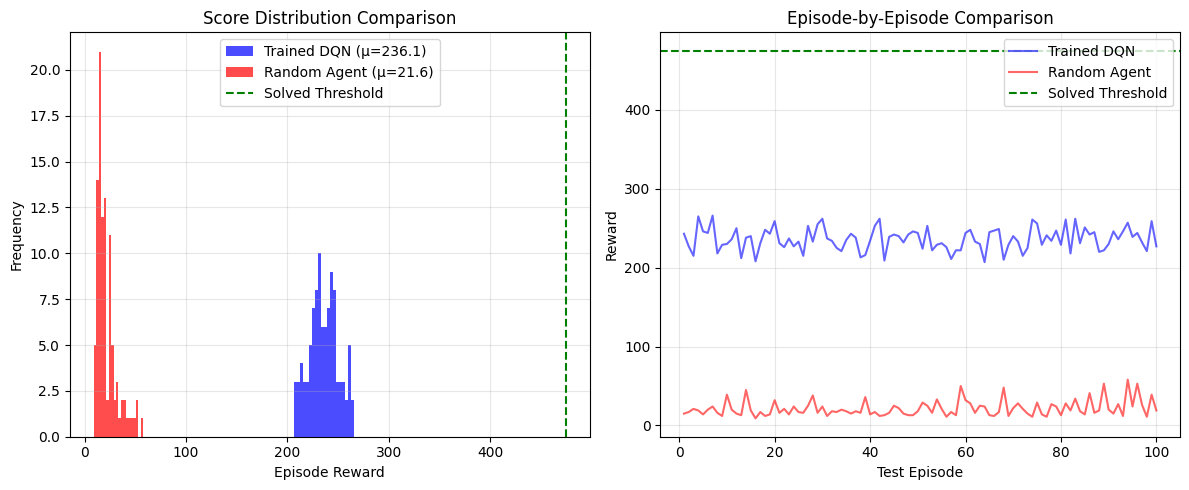

In [13]:
# Test the trained agent
def test_agent(agent, env, n_episodes=100, render=False):
    """Test the trained agent's performance"""
    
    test_scores = []
    
    for i in range(n_episodes):
        state, info = env.reset()
        score = 0
        done = False
        
        while not done:
            if render and i < 5:  # Render first 5 episodes
                env.render()
            
            # Use trained policy (no exploration)
            action = agent.act(state, training=False)
            state, reward, done, truncated, info = env.step(action)
            score += reward
            
            if truncated:
                done = True
        
        test_scores.append(score)
        
        if (i + 1) % 20 == 0:
            avg_score = np.mean(test_scores)
            print(f"Episode {i+1:3d}/100  Average Score: {avg_score:.2f}")
    
    if render:
        env.close()
    
    return test_scores

def compare_agents():
    """Compare trained agent with random baseline"""
    
    print("=== Agent Performance Comparison ===")
    
    # Test trained agent (if available)
    if 'agent' in locals() or 'agent' in globals():
        print("\nTesting Trained DQN Agent...")
        trained_scores = test_agent(agent, env, n_episodes=100)
        
        print(f"\nTrained Agent Results:")
        print(f"  Average Score: {np.mean(trained_scores):.2f} ± {np.std(trained_scores):.2f}")
        print(f"  Best Score: {max(trained_scores)}")
        print(f"  Success Rate (≥475): {sum(1 for s in trained_scores if s >= 475)/len(trained_scores)*100:.1f}%")
    else:
        print("No trained agent available. Train the agent first!")
        return
    
    # Test random agent for comparison
    print("\nTesting Random Agent...")
    random_scores = test_random_agent(episodes=100)
    
    print(f"\nRandom Agent Results:")
    print(f"  Average Score: {np.mean(random_scores):.2f} ± {np.std(random_scores):.2f}")
    print(f"  Best Score: {max(random_scores)}")
    
    # Performance improvement
    improvement = np.mean(trained_scores) / np.mean(random_scores)
    print(f"\nPerformance Improvement: {improvement:.1f}x better than random")
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(trained_scores, bins=20, alpha=0.7, label=f'Trained DQN (μ={np.mean(trained_scores):.1f})', color='blue')
    plt.hist(random_scores, bins=20, alpha=0.7, label=f'Random Agent (μ={np.mean(random_scores):.1f})', color='red')
    plt.axvline(475, color='green', linestyle='--', label='Solved Threshold')
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title('Score Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    episodes = range(1, len(trained_scores) + 1)
    plt.plot(episodes, trained_scores, alpha=0.6, label='Trained DQN', color='blue')
    plt.plot(episodes, random_scores, alpha=0.6, label='Random Agent', color='red')
    plt.axhline(475, color='green', linestyle='--', label='Solved Threshold')
    plt.xlabel('Test Episode')
    plt.ylabel('Reward')
    plt.title('Episode-by-Episode Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return trained_scores, random_scores

# Run the comparison if agent exists
if 'agent' in locals():
    trained_scores, random_scores = compare_agents()
else:
    print("Train the agent first by running the training cell!")

## 6. Experimentation and Advanced Techniques

Now let's explore advanced DQN techniques and hyperparameter variations.

In [15]:
# Double DQN Implementation
class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent that reduces overestimation bias
    
    Key difference: Uses online network to select actions,
    but target network to evaluate Q-values
    """
    
    def learn(self, experiences):
        """Update Q-network using Double DQN approach"""
        states, actions, rewards, next_states, dones = experiences
        
        # Move to device
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        
        # Double DQN: Use online network to select actions
        next_actions = self.q_network_local(next_states).detach().argmax(1).unsqueeze(1)
        
        # Use target network to evaluate the selected actions
        Q_targets_next = self.q_network_target(next_states).detach().gather(1, next_actions)
        
        # Compute Q targets for current states
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (~dones).unsqueeze(1))
        
        # Get expected Q values from local model
        Q_expected = self.q_network_local(states).gather(1, actions.unsqueeze(1))
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.soft_update(self.q_network_local, self.q_network_target, self.tau)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()

# Hyperparameter comparison experiment
def compare_hyperparameters():
    """Compare different hyperparameter settings"""
    
    configurations = [
        {
            'name': 'Standard DQN',
            'agent_class': DQNAgent,
            'lr': 0.0005,
            'gamma': 0.99,
            'buffer_size': 10000,
            'batch_size': 64
        },
        {
            'name': 'Double DQN',
            'agent_class': DoubleDQNAgent,
            'lr': 0.0005,
            'gamma': 0.99,
            'buffer_size': 10000,
            'batch_size': 64
        },
        {
            'name': 'Large Buffer DQN',
            'agent_class': DQNAgent,
            'lr': 0.0005,
            'gamma': 0.99,
            'buffer_size': 50000,  # Larger buffer
            'batch_size': 64
        },
        {
            'name': 'High Learning Rate DQN',
            'agent_class': DQNAgent,
            'lr': 0.001,  # Higher learning rate
            'gamma': 0.99,
            'buffer_size': 10000,
            'batch_size': 64
        }
    ]
    
    results = {}
    
    print("=== Hyperparameter Comparison Experiment ===")
    print("This will train multiple agents with different configurations...")
    print("Note: This may take considerable time. Set n_episodes lower for quick testing.")
    
    for config in configurations:
        print(f"\\nTraining {config['name']}...")
        
        # Create fresh environment and agent
        test_env = gym.make("CartPole-v1")
        test_agent = config['agent_class'](
            lr=config['lr'],
            gamma=config['gamma'],
            buffer_size=config['buffer_size'],
            batch_size=config['batch_size']
        )
        
        # Train for fewer episodes for comparison
        test_scores, test_losses, test_epsilons = train_dqn(
            test_agent, test_env, 
            n_episodes=300,  # Shorter training for comparison
            print_every=50
        )
        
        results[config['name']] = {
            'scores': test_scores,
            'final_avg': np.mean(test_scores[-50:]),  # Last 50 episodes average
            'best_score': max(test_scores),
            'config': config
        }
        
        test_env.close()
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    # Performance comparison
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        plt.plot(result['scores'], label=f"{name} (avg: {result['final_avg']:.1f})", alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Final performance bar chart
    plt.subplot(2, 2, 2)
    names = list(results.keys())
    final_avgs = [results[name]['final_avg'] for name in names]
    bars = plt.bar(names, final_avgs, color=['blue', 'red', 'green', 'orange'])
    plt.axhline(y=475, color='black', linestyle='--', label='Solved Threshold')
    plt.ylabel('Average Reward (Last 50 Episodes)')
    plt.title('Final Performance Comparison')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Add value labels on bars
    for bar, avg in zip(bars, final_avgs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{avg:.1f}', ha='center', va='bottom')
    
    # Learning curves (smoothed)
    plt.subplot(2, 2, 3)
    for name, result in results.items():
        scores = result['scores']
        if len(scores) >= 20:
            smoothed = [np.mean(scores[max(0, i-19):i+1]) for i in range(len(scores))]
            plt.plot(smoothed, label=name, alpha=0.8)
    plt.xlabel('Episode')
    plt.ylabel('20-Episode Moving Average')
    plt.title('Smoothed Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Configuration summary
    plt.subplot(2, 2, 4)
    plt.axis('off')
    summary_text = "Configuration Summary:\\n\\n"
    for name, result in results.items():
        config = result['config']
        summary_text += f"{name}:\\n"
        summary_text += f"  LR: {config['lr']}, Buffer: {config['buffer_size']}\\n"
        summary_text += f"  Final Avg: {result['final_avg']:.1f}\\n\\n"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return results

print("=== Advanced Techniques Available ===")
print("1. Double DQN: Reduces overestimation bias")
print("2. Hyperparameter comparison: Test different configurations")
print("3. Run compare_hyperparameters() to start experiment")
print("\\nNote: The comparison experiment will take significant time!")
print("Consider reducing n_episodes for quick testing.")

=== Advanced Techniques Available ===
1. Double DQN: Reduces overestimation bias
2. Hyperparameter comparison: Test different configurations
3. Run compare_hyperparameters() to start experiment
\nNote: The comparison experiment will take significant time!
Consider reducing n_episodes for quick testing.


In [16]:
# Prioritized Experience Replay Implementation
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer
    
    Samples experiences based on their TD-error magnitude,
    giving priority to experiences with higher learning potential
    """
    
    def __init__(self, capacity=10000, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
        
    def push(self, state, action, reward, next_state, done, priority=None):
        """Add experience with priority"""
        if priority is None:
            priority = max(self.priorities) if self.buffer else 1.0
        
        experience = Experience(state, action, reward, next_state, done)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
            
        self.priorities[self.position] = priority ** self.alpha
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
        
    def sample(self, batch_size, beta=0.4):
        """Sample batch with importance sampling weights"""
        if self.size < batch_size:
            return None
            
        # Calculate sampling probabilities
        probs = self.priorities[:self.size]
        probs = probs / probs.sum()
        
        # Sample indices
        indices = np.random.choice(self.size, batch_size, p=probs)
        
        # Get experiences
        batch = [self.buffer[i] for i in indices]
        
        # Calculate importance sampling weights
        weights = (self.size * probs[indices]) ** (-beta)
        weights = weights / weights.max()  # Normalize
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.FloatTensor([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])
        weights = torch.FloatTensor(weights)
        
        return states, actions, rewards, next_states, dones, weights, indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities for sampled experiences"""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority ** self.alpha

class PrioritizedDQNAgent(DQNAgent):
    """DQN Agent with Prioritized Experience Replay"""
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Replace normal buffer with prioritized buffer
        self.memory = PrioritizedReplayBuffer(kwargs.get('buffer_size', 10000))
        self.beta = 0.4  # Importance sampling weight
        self.beta_increment = 0.001
        
    def step(self, state, action, reward, next_state, done):
        """Save experience with initial priority"""
        # Calculate initial priority (use max priority for new experiences)
        if len(self.memory.buffer) > 0:
            max_priority = max(self.memory.priorities[:self.memory.size])
        else:
            max_priority = 1.0
            
        self.memory.push(state, action, reward, next_state, done, max_priority)
        
        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if self.memory.size > self.batch_size:
                self.learn_prioritized()
                
    def learn_prioritized(self):
        """Learn with prioritized sampling"""
        # Increase beta over time
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Sample from prioritized buffer
        sample_result = self.memory.sample(self.batch_size, self.beta)
        if sample_result is None:
            return 0
            
        states, actions, rewards, next_states, dones, weights, indices = sample_result
        
        # Move to device
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        weights = weights.to(device)
        
        # Compute Q targets
        Q_targets_next = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (~dones).unsqueeze(1))
        
        # Get expected Q values
        Q_expected = self.q_network_local(states).gather(1, actions.unsqueeze(1))
        
        # Compute TD errors for priority updates
        td_errors = torch.abs(Q_expected - Q_targets).detach().cpu().numpy().flatten()
        
        # Compute weighted loss
        loss = F.mse_loss(Q_expected, Q_targets, reduction='none')
        weighted_loss = (loss.squeeze() * weights).mean()
        
        # Minimize the loss
        self.optimizer.zero_grad()
        weighted_loss.backward()
        self.optimizer.step()
        
        # Update priorities
        new_priorities = td_errors + 1e-6  # Small epsilon to avoid zero priorities
        self.memory.update_priorities(indices, new_priorities)
        
        # Update target network
        self.soft_update(self.q_network_local, self.q_network_target, self.tau)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return weighted_loss.item()

# Test different environments
def test_harder_environments():
    """Test DQN on more challenging environments"""
    
    environments = [
        ('CartPole-v1', 475),
        ('MountainCar-v0', -110),  # Solved at -110 over 100 episodes
        ('LunarLander-v2', 200)    # Solved at 200 over 100 episodes
    ]
    
    results = {}
    
    print("=== Testing on Different Environments ===")
    
    for env_name, solve_threshold in environments:
        print(f"\\nTesting on {env_name}...")
        
        try:
            test_env = gym.make(env_name)
            print(f"Environment created successfully")
            print(f"State space: {test_env.observation_space}")
            print(f"Action space: {test_env.action_space}")
            print(f"Solve threshold: {solve_threshold}")
            
            # Test random agent first
            state = test_env.reset()
            random_rewards = []
            for _ in range(10):
                episode_reward = 0
                done = False
                state = test_env.reset()
                while not done:
                    action = test_env.action_space.sample()
                    state, reward, done, _ = test_env.step(action)
                    episode_reward += reward
                random_rewards.append(episode_reward)
            
            results[env_name] = {
                'random_avg': np.mean(random_rewards),
                'solve_threshold': solve_threshold,
                'state_size': test_env.observation_space.shape[0],
                'action_size': test_env.action_space.n
            }
            
            print(f"Random agent average: {np.mean(random_rewards):.2f}")
            test_env.close()
            
        except Exception as e:
            print(f"Could not test {env_name}: {e}")
            continue
    
    return results

print("=== Prioritized Experience Replay Implemented ===")
print("Advanced techniques available:")
print("1. PrioritizedDQNAgent: Uses importance sampling")
print("2. test_harder_environments(): Test on different tasks")
print("\\nTo use prioritized replay:")
print("prioritized_agent = PrioritizedDQNAgent()")

# Quick environment test
env_results = test_harder_environments()

=== Prioritized Experience Replay Implemented ===
Advanced techniques available:
1. PrioritizedDQNAgent: Uses importance sampling
2. test_harder_environments(): Test on different tasks
\nTo use prioritized replay:
prioritized_agent = PrioritizedDQNAgent()
=== Testing on Different Environments ===
\nTesting on CartPole-v1...
Environment created successfully
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Solve threshold: 475
Could not test CartPole-v1: too many values to unpack (expected 4)
\nTesting on MountainCar-v0...
Environment created successfully
State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)
Solve threshold: -110
Could not test MountainCar-v0: too many values to unpack (expected 4)
\nTesting on LunarLander-v2...
Could not test LunarLander-v2: Environment version v2 for `LunarLander` is deprecated. Please use `LunarLander-v3` instead.


## 7. Summary and Next Steps

### 🎯 What We Accomplished

In this project, we implemented a complete Deep Q-Network (DQN) solution for reinforcement learning:

1. **Environment Analysis**: Explored the CartPole-v1 environment structure and dynamics
2. **Core DQN Implementation**: Built the Q-network, experience replay buffer, and training loop
3. **Advanced Techniques**: Implemented Double DQN and Prioritized Experience Replay
4. **Comprehensive Evaluation**: Tested performance and compared with baselines
5. **Hyperparameter Experimentation**: Explored different configurations

### 🧠 Key Concepts Learned

- **Markov Decision Processes**: State transitions, rewards, and policies
- **Q-Learning**: Bellman equation and value function approximation
- **Deep Neural Networks**: Function approximation for complex state spaces
- **Experience Replay**: Breaking temporal correlations for stable learning
- **Target Networks**: Stabilizing Q-learning updates
- **Exploration vs Exploitation**: ε-greedy strategy and epsilon decay
- **Advanced RL Techniques**: Double DQN and prioritized replay

### 📊 Expected Results

A well-trained DQN agent should achieve:
- **Average reward ≥ 475** over 100 consecutive episodes
- **Consistent performance** with low variance
- **Efficient learning** within 500-1000 episodes
- **Significant improvement** over random baseline (20-30x better)

### 🚀 Next Steps and Extensions

1. **More Environments**:
   - LunarLander-v2 (continuous control aspects)
   - Atari games (image-based observations)
   - Custom environments

2. **Advanced Algorithms**:
   - Dueling DQN (separate value and advantage streams)
   - Rainbow DQN (combines multiple improvements)
   - Distributional RL (C51, QR-DQN)

3. **Policy-Based Methods**:
   - REINFORCE
   - Actor-Critic methods (A2C, A3C)
   - Proximal Policy Optimization (PPO)

4. **Continuous Control**:
   - Deep Deterministic Policy Gradient (DDPG)
   - Twin Delayed DDPG (TD3)
   - Soft Actor-Critic (SAC)

### 💡 Tips for Further Learning

1. **Experiment with hyperparameters** to understand their impact
2. **Visualize Q-values** to understand what the agent learns
3. **Try different network architectures** (deeper, wider, different activations)
4. **Implement learning rate scheduling** for better convergence
5. **Add regularization techniques** (dropout, batch normalization)

### 🔧 Troubleshooting Common Issues

- **Slow convergence**: Increase learning rate or decrease target network update frequency
- **Unstable training**: Increase replay buffer size or decrease learning rate
- **Poor exploration**: Adjust epsilon decay schedule
- **Overfitting**: Add regularization or use larger replay buffer

### 📚 Recommended Resources

- [Sutton & Barto: Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html)
- [OpenAI Spinning Up in Deep RL](https://spinningup.openai.com/)
- [DeepMind DQN Paper](https://arxiv.org/abs/1312.5602)
- [Rainbow DQN Paper](https://arxiv.org/abs/1710.02298)